# Create, evaluate, and score a churn prediction model

## Introduction

In this notebook, you'll see a Microsoft Fabric data science workflow with an end-to-end example. The scenario is to build a model to predict whether bank customers would churn or not. The churn rate, also known as the rate of attrition refers to the rate at which bank customers stop doing business with the bank.

The summary of main steps you take in this notebook are as following:

- Install custom libraries.
- Load the data.
- Understand and process the data through exploratory data analysis.
- Train machine learning models by using scikit-learn and LightGBM.
- Evaluate and save the final machine learning model.
- Demonstrate the model's performance via visualizations in Power BI.


## Prerequisites
- [Add a lakehouse](https://aka.ms/fabric/addlakehouse) to this notebook. You will be downloading data from a public blob, then storing the data in the lakehouse. 

## Step 1: Install custom libraries


For machine learning model development or ad-hoc data analysis, you might need to quickly install a custom library for your Apache Spark session. You have two options to install libraries.

* Use inline installation resources, for example `install.packages` and `devtools::install_version`, to install in your current notebook only.
* Alternatively, you can create a Fabric environment, install libraries from public sources or upload custom libraries to it, and then your workspace admin can attach the environment as the default for the workspace. All the libraries in the environment will then become available for use in any notebooks and Spark job definitions in the workspace. For more information on environments, see [create, configure, and use an environment in Microsoft Fabric](https://aka.ms/fabric/create-environment).

In this tutorial, use `install.packages()` to install the `imbalance` and `randomForest` libraries. Set `quiet` to `TRUE` to make the output more concise:

In this notebook, you will be using the `imbalance` and `randomForest` libraries.  

In the following, you'll use `install.packages()` to install the these libraries.  Set `quiet` to `TRUE` to make output more concise.

In [ ]:
# Install dependencies
devtools::install_version("bnlearn", version = "4.8")
# Install imbalance for SMOTE
devtools::install_version("imbalance", version = "1.0.2.1")
# Install the random forest algorithm
devtools::install_version("randomForest", version = "4.7-1.1")

StatementMeta(, 3753b326-451b-4e6b-bf24-9f1372d6e5da, 3, Finished, Available)

nfs is ready retry=1
begin to create dir /nfs4/R/user-lib/application_1694809280385_0001.
begin to confige user lib /nfs4/R/user-lib/application_1694809280385_0001.
success to confige user lib /nfs4/R/user-lib/application_1694809280385_0001
start install.packages pkgs=imbalance time:2023-09-15 20:23:23
also installing the dependencies ‘libcoin’, ‘Formula’, ‘inum’, ‘dbscan’, ‘Cubist’, ‘partykit’, ‘bnlearn’, ‘KernelKnn’, ‘mvtnorm’, ‘smotefamily’, ‘FNN’, ‘C50’, ‘RcppArmadillo’

[notebook] install.packages pkgs=imbalance cost [253s] time:2023-09-15 20:27:36
start install.packages pkgs=randomForest time:2023-09-15 20:27:36
[notebook] install.packages pkgs=randomForest cost [9s] time:2023-09-15 20:27:45

## Step 2: Load the data


#### Dataset

The dataset in *churn.csv* contains the churn status of 10,000 customers, along with 14 attributes that include:

- Credit score
- Geographical location (Germany, France, Spain)
- Gender (male, female)
- Age
- Tenure (number of years the person was a customer at that bank)
- Account balance
- Estimated salary
- Number of products that a customer purchased through the bank
- Credit card status (whether or not a customer has a credit card)
- Active member status (whether or not the person is an active bank customer)

The dataset also includes row number, customer ID, and customer surname columns. Values in these columns shouldn't influence a customer's decision to leave the bank.

A customer bank account closure event defines the churn for that customer. The dataset `Exited` column refers to the customer's abandonment. Since we have little context about these attributes, we don't need background information about the dataset. We want to understand how these attributes contribute to the `Exited` status.

Out of the 10,000 customers, only 2037 customers (around 20%) left the bank. Because of the class imbalance ratio, we recommend generating synthetic data generation.

This table shows a preview sample of the `churn.csv` data:


|"CustomerID"|"Surname"|"CreditScore"|"Geography"|"Gender"|"Age"|"Tenure"|"Balance"|"NumOfProducts"|"HasCrCard"|"IsActiveMember"|"EstimatedSalary"|"Exited"|
|---|---|---|---|---|---|---|---|---|---|---|---|---|
|15634602|Hargrave|619|France|Female|42|2|0.00|1|1|1|101348.88|1|
|15647311|Hill|608|Spain|Female|41|1|83807.86|1|0|1|112542.58|0|



#### Download dataset and upload to lakehouse

> [Add a lakehouse](https://aka.ms/fabric/addlakehouse) to the notebook before you run it. Failure to do so will result in an error.

This code downloads a publicly available version of the dataset, and then stores that data in a Fabric lakehouse:

In [ ]:
library(fs)
library(httr)

remote_url <- "https://sdkstorerta.blob.core.windows.net/churnblob"
file_list <- c("churn.csv")
download_path <- "/lakehouse/default/Files/churn/raw"

if (!dir_exists("/lakehouse/default")) {
  stop("Default lakehouse not found, please add a lakehouse and restart the session.")
}
dir_create(download_path, recurse= TRUE)
for (fname in file_list) {
  if (!file_exists(paste0(download_path, "/", fname))) {
    r <- GET(paste0(remote_url, "/", fname), timeout(30))
    writeBin(content(r, "raw"), paste0(download_path, "/", fname))
  }
}
print("Downloaded demo data files into lakehouse.")

StatementMeta(, 3753b326-451b-4e6b-bf24-9f1372d6e5da, 4, Finished, Available)

[1] "Downloaded demo data files into lakehouse."

Start recording the time needed to run this notebook:

In [ ]:
# Record the notebook running time
ts <- as.numeric(Sys.time())

StatementMeta(, 3753b326-451b-4e6b-bf24-9f1372d6e5da, 5, Finished, Available)

### Read raw date data from the lakehouse

This code reads raw data from the **Files** section of the lakehouse:

In [ ]:
fname <- "churn.csv"
download_path <- "/lakehouse/default/Files/churn/raw"
rdf <- readr::read_csv(paste0(download_path, "/", fname))

StatementMeta(, 3753b326-451b-4e6b-bf24-9f1372d6e5da, 6, Finished, Available)

Rows: 10000 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (3): Surname, Geography, Gender
dbl (11): RowNumber, CustomerId, CreditScore, Age, Tenure, Balance, NumOfPro...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

## Step 3: Perform exploratory data analysis

### Display raw data

Use the `head()` or `str()` commands to perform a preliminary exploration of the raw data:  

In [ ]:
head(rdf)

StatementMeta(, 3753b326-451b-4e6b-bf24-9f1372d6e5da, 7, Finished, Available)

# A tibble: 6 × 14
  RowNumber Custom…¹ Surname Credi…² Geogr…³ Gender   Age Tenure Balance NumOf…⁴
      <dbl>    <dbl> <chr>     <dbl> <chr>   <chr>  <dbl>  <dbl>   <dbl>   <dbl>
1         1 15634602 Hargra…     619 France  Female    42      2      0        1
2         2 15647311 Hill        608 Spain   Female    41      1  83808.       1
3         3 15619304 Onio        502 France  Female    42      8 159661.       3
4         4 15701354 Boni        699 France  Female    39      1      0        2
5         5 15737888 Mitche…     850 Spain   Female    43      2 125511.       1
6         6 15574012 Chu         645 Spain   Male      44      8 113756.       2
# … with 4 more variables: HasCrCard <dbl>, IsActiveMember <dbl>,
#   EstimatedSalary <dbl>, Exited <dbl>, and abbreviated variable names
#   ¹​CustomerId, ²​CreditScore, ³​Geography, ⁴​NumOfProducts

### Perform initial data cleaning

You must convert the R DataFrame to a Spark DataFrame. These operations on the Spark DataFrame clean the raw dataset:

- Drop the rows that have missing data across all columns.
- Drop the duplicate rows across the columns `RowNumber` and `CustomerId`.
- Drop the columns `RowNumber`, `CustomerId`, and `Surname`.

In [ ]:
# Transform the R DataFrame to a Spark DataFrame
df <- as.DataFrame(rdf)

clean_data <- function(df) {
  sdf <- df %>%
    # Drop rows that have missing data across all columns
    na.omit() %>%
    # Drop duplicate rows in columns: 'RowNumber', 'CustomerId'
    dropDuplicates(c("RowNumber", "CustomerId")) %>%
    # Drop columns: 'RowNumber', 'CustomerId', 'Surname'
    SparkR::select("CreditScore", "Geography", "Gender", "Age", "Tenure", "Balance", "NumOfProducts", "HasCrCard", "IsActiveMember", "EstimatedSalary", "Exited")
  return(sdf)
}

df_clean <- clean_data(df)

StatementMeta(, 3753b326-451b-4e6b-bf24-9f1372d6e5da, 8, Finished, Available)

Explore the Spark DataFrame with the `display` command:

In [ ]:
display(df_clean)

StatementMeta(, 3753b326-451b-4e6b-bf24-9f1372d6e5da, 9, Finished, Available)

SynapseWidget(Synapse.DataFrame, a7262038-863d-4a52-aeb6-a8a34343e300)

This code determines the categorical, numerical, and target attributes:

In [ ]:
# Determine the dependent (target) attribute
dependent_variable_name <- "Exited"
print(dependent_variable_name)

# Obtain the distinct values for each column
exprs = lapply(names(df_clean), function(x) alias(countDistinct(df_clean[[x]]), x))
# Use do.call to splice the aggregation expressions to aggregate function
distinct_value_number <- SparkR::collect(do.call(agg, c(x = df_clean, exprs)))

# Determine the categorical attributes
categorical_variables <- names(df_clean)[sapply(names(df_clean), function(col) col %in% c("0") || distinct_value_number[[col]] <= 5 && !(col %in% c(dependent_variable_name)))]
print(categorical_variables)

# Determine the numerical attributes
numeric_variables <- names(df_clean)[sapply(names(df_clean), function(col) coltypes(SparkR::select(df_clean, col)) == "numeric" && distinct_value_number[[col]] > 5)]
print(numeric_variables)

StatementMeta(, 3753b326-451b-4e6b-bf24-9f1372d6e5da, 10, Finished, Available)

[1] "Exited"
[1] "Geography"      "Gender"         "NumOfProducts"  "HasCrCard"     
[5] "IsActiveMember"
[1] "CreditScore"     "Age"             "Tenure"          "Balance"        
[5] "EstimatedSalary"

For easier processing and visualization, convert the cleaned Spark DataFrame to an R DataFrame:

In [ ]:
# Transform the Spark DataFrame to an R DataFrame
rdf_clean <- SparkR::collect(df_clean)

StatementMeta(, 3753b326-451b-4e6b-bf24-9f1372d6e5da, 11, Finished, Available)

### Show the five-number summary 

Use box plots to show the five-number summary (minimum score, first quartile, median, third quartile, maximum score) for the numerical attributes:

StatementMeta(, 3753b326-451b-4e6b-bf24-9f1372d6e5da, 12, Finished, Available)

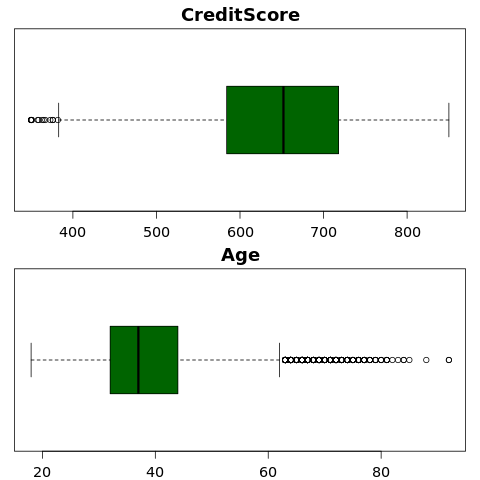

In [ ]:
# Set the overall layout of the graphics window
par(mfrow = c(2, 1), 
    mar = c(2, 1, 2, 1)) # Margin size

for(item in numeric_variables[1:2]){
    # Create a box plot
    boxplot(rdf_clean[, item], 
            main = item, 
            col = "darkgreen", 
            cex.main = 1.5, # Title size
            cex.lab = 1.3, # Axis label size
            cex.axis = 1.2,
            horizontal = TRUE) # Axis size
}

StatementMeta(, 3753b326-451b-4e6b-bf24-9f1372d6e5da, 13, Finished, Available)

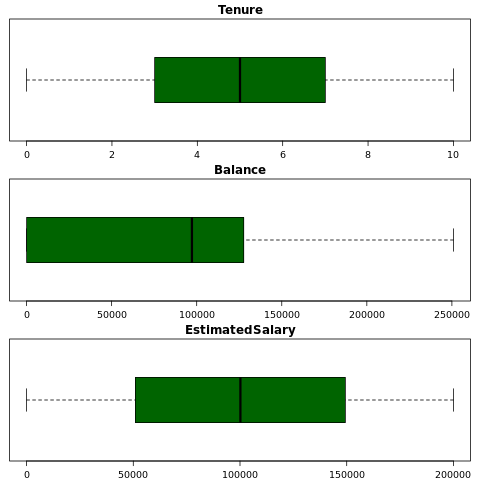

In [ ]:
# Set the overall layout of the graphics window
par(mfrow = c(3, 1), 
    mar = c(2, 1, 2, 1)) # Margin size

for(item in numeric_variables[3:5]){
    # Create box plot
    boxplot(rdf_clean[, item], 
            main = item, 
            col = "darkgreen", 
            cex.main = 1.5, # Title size
            cex.lab = 1.3, # Axis label size
            cex.axis = 1.2,
            horizontal = TRUE) # Axis size
}

### Show the distribution of exited and non-exited customers

Show the distribution of exited versus non-exited customers across the categorical attributes:

StatementMeta(, 3753b326-451b-4e6b-bf24-9f1372d6e5da, 14, Finished, Available)

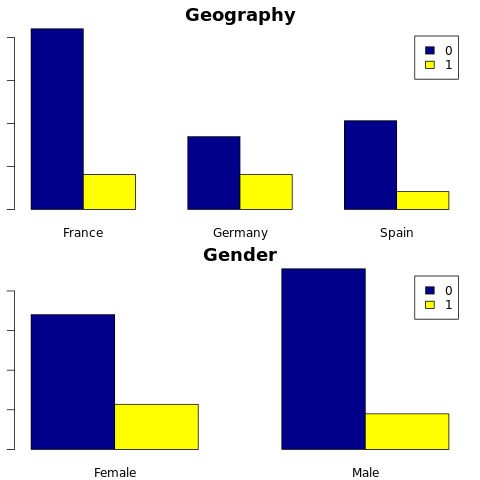

In [ ]:
attr_list <- c('Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'NumOfProducts', 'Tenure')
par(mfrow = c(2, 1), 
    mar = c(2, 1, 2, 1)) # Margin size
for (item in attr_list[1:2]) {
    counts <- table(rdf_clean$Exited, rdf_clean[,item])
    barplot(counts, main=item, col=c("darkblue","yellow"), 
            cex.main = 1.5, # Title size
            cex.axis = 1.2,
            legend = rownames(counts), beside=TRUE)
}


StatementMeta(, 3753b326-451b-4e6b-bf24-9f1372d6e5da, 15, Finished, Available)

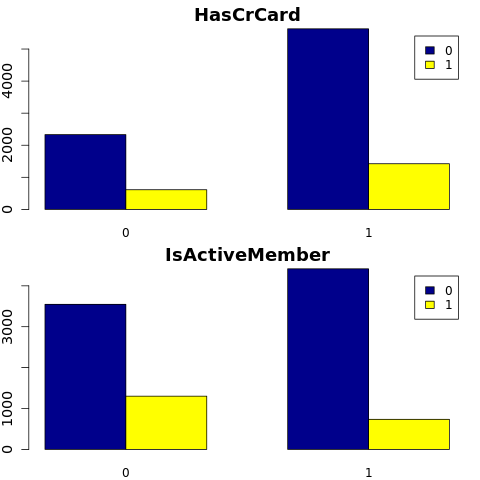

In [ ]:
par(mfrow = c(2, 1), 
    mar = c(2, 2, 2, 1)) # Margin size
for (item in attr_list[3:4]) {
    counts <- table(rdf_clean$Exited, rdf_clean[,item])
    barplot(counts, main=item, col=c("darkblue","yellow"), 
            cex.main = 1.5, # Title size
            cex.axis = 1.2,
            legend = rownames(counts), beside=TRUE)
}

StatementMeta(, 3753b326-451b-4e6b-bf24-9f1372d6e5da, 16, Finished, Available)

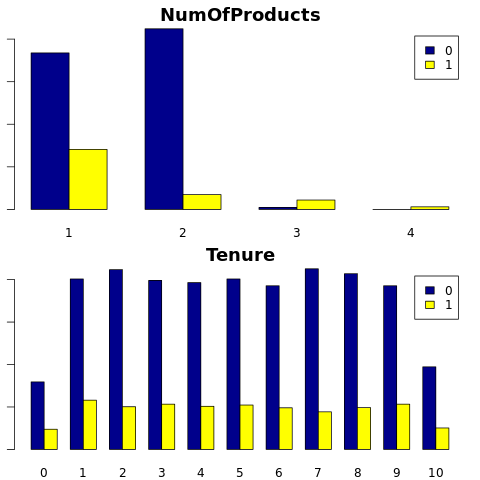

In [ ]:
par(mfrow = c(2, 1), 
    mar = c(2, 1, 2, 1)) # Margin size
for (item in attr_list[5:6]) {
    counts <- table(rdf_clean$Exited, rdf_clean[,item])
    barplot(counts, main=item, col=c("darkblue","yellow"), 
            cex.main = 1.5, # Title size
            cex.axis = 1.2,
            legend = rownames(counts), beside=TRUE)
}

### Show the distribution of numerical attributes

Use a histogram to show the frequency distribution of numerical attributes:

StatementMeta(, 3753b326-451b-4e6b-bf24-9f1372d6e5da, 17, Finished, Available)

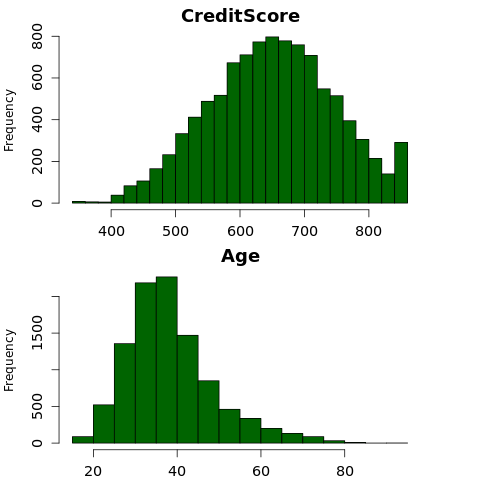

In [ ]:
# Set the overall layout of the graphics window
par(mfrow = c(2, 1), 
    mar = c(2, 4, 2, 4) + 0.1) # Margin size

# Create histograms
for (item in numeric_variables[1:2]) {
    hist(rdf_clean[, item], 
         main = item, 
         col = "darkgreen", 
         xlab = item,
         cex.main = 1.5, # Title size
         cex.axis = 1.2,
         breaks = 20) # Number of bins
}

StatementMeta(, 3753b326-451b-4e6b-bf24-9f1372d6e5da, 18, Finished, Available)

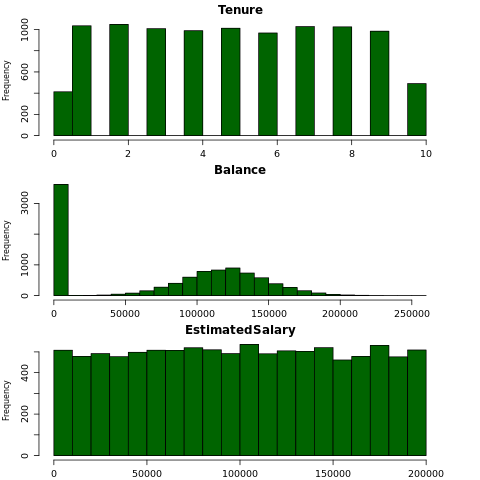

In [ ]:
# Set the overall layout of the graphics window
par(mfrow = c(3, 1), 
    mar = c(2, 4, 2, 4) + 0.1) # Margin size

# Create histograms
for (item in numeric_variables[3:5]) {
    hist(rdf_clean[, item], 
         main = item, 
         col = "darkgreen", 
         xlab = item,
         cex.main = 1.5, # Title size
         cex.axis = 1.2,
         breaks = 20) # Number of bins
}

#### Perform feature engineering

This feature engineering generates new attributes based on current attributes:

In [ ]:
rdf_clean$NewTenure <- rdf_clean$Tenure / rdf_clean$Age
rdf_clean$NewCreditsScore <- as.numeric(cut(rdf_clean$CreditScore, breaks=quantile(rdf_clean$CreditScore, probs=seq(0, 1, by=1/6)), include.lowest=TRUE, labels=c(1, 2, 3, 4, 5, 6)))
rdf_clean$NewAgeScore <- as.numeric(cut(rdf_clean$Age, breaks=quantile(rdf_clean$Age, probs=seq(0, 1, by=1/8)), include.lowest=TRUE, labels=c(1, 2, 3, 4, 5, 6, 7, 8)))
rdf_clean$NewBalanceScore <- as.numeric(cut(rank(rdf_clean$Balance), breaks=quantile(rank(rdf_clean$Balance, ties.method = "first"), probs=seq(0, 1, by=1/5)), include.lowest=TRUE, labels=c(1, 2, 3, 4, 5)))
rdf_clean$NewEstSalaryScore <- as.numeric(cut(rdf_clean$EstimatedSalary, breaks=quantile(rdf_clean$EstimatedSalary, probs=seq(0, 1, by=1/10)), include.lowest=TRUE, labels=c(1:10)))

StatementMeta(, 3753b326-451b-4e6b-bf24-9f1372d6e5da, 19, Finished, Available)

#### Perform one-hot encoding

Use one-hot encoding to convert the categorical attributes to numerical attributes, to feed them into the machine learning model:

In [ ]:
rdf_clean <- cbind(rdf_clean, model.matrix(~Geography+Gender-1, data=rdf_clean))
rdf_clean <- subset(rdf_clean, select = - c(Geography, Gender))

StatementMeta(, 3753b326-451b-4e6b-bf24-9f1372d6e5da, 20, Finished, Available)

#### Create a delta table to generate the Power BI report

In [ ]:
table_name <- "rdf_clean"
# Create a Spark DataFrame from an R DataFrame
sparkDF <- as.DataFrame(rdf_clean)
write.df(sparkDF, paste0("Tables/", table_name), source = "delta", mode = "overwrite")
cat(paste0("Spark DataFrame saved to delta table: ", table_name))

StatementMeta(, 3753b326-451b-4e6b-bf24-9f1372d6e5da, 21, Finished, Available)

Spark dataframe saved to delta table: rdf_clean

#### Summary of observations from the exploratory data analysis

- Most of the customers are from France. Spain has the lowest churn rate, compared to France and Germany
- Some customers are both over the age of 60 and have credit scores below 400. However, they can't be considered as outliers
- Few customers have more than two bank products
- Inactive customers have a higher churn rate
- Gender and tenure years have little impact on a customer's decision to close a bank account


## Step 4: Perform model training

With the data in place, you can now define the model. Apply Random Forest and LightGBM models. Use `randomForest` and `LightGBM` to implement the models with a few lines of code.

Load the delta table from the lakehouse. You can use other delta tables that consider the lakehouse as the source.

In [ ]:
SEED <- 12345
rdf_clean <- read.df("Tables/rdf_clean", source = "delta")
df_clean <- as.data.frame(rdf_clean)

StatementMeta(, 3753b326-451b-4e6b-bf24-9f1372d6e5da, 22, Finished, Available)

Import `randomForest` and `lightgbm`:

In [ ]:
library(randomForest)
library(lightgbm)

StatementMeta(, 3753b326-451b-4e6b-bf24-9f1372d6e5da, 23, Finished, Available)

randomForest 4.7-1.1
Type rfNews() to see new features/changes/bug fixes.
Loading required package: R6

Attaching package: ‘lightgbm’

The following object is masked from ‘package:SparkR’:

    slice


Prepare the training and testing datasets:

In [ ]:
set.seed(SEED)
y <- factor(df_clean$Exited)
X <- df_clean[, !(colnames(df_clean) %in% c("Exited"))]
split <- base::sample(c(TRUE, FALSE), nrow(df_clean), replace = TRUE, prob = c(0.8, 0.2))
X_train <- X[split,]
X_test <- X[!split,]
y_train <- y[split]
y_test <- y[!split]
train_df <- cbind(X_train, y_train)

StatementMeta(, 3753b326-451b-4e6b-bf24-9f1372d6e5da, 24, Finished, Available)

### Apply SMOTE to the training dataset

Imbalanced classification has a problem, because it has too few examples of the minority class for a model to effectively learn the decision boundary. To handle this, Synthetic Minority Oversampling Technique (SMOTE) is the most widely used technique to synthesize new samples for the minority class. Access SMOTE with the `imblearn` library that you installed in step 1.

Apply SMOTE only to the training dataset. You must leave the test dataset in its original imbalanced distribution, to get a valid approximation of model performance on the original data. This experiment represents the situation in production.

First, show the distribution of classes in the dataset, to learn which class is the minority class. The ratio of minority class to majority class is defined as `imbalance Ratio` in the `imbalance` library.

In [ ]:
original_ratio <- imbalance::imbalanceRatio(train_df, classAttr = "y_train")
message(sprintf("Original imbalance ratio is %.2f%% as {Size of minority class}/{Size of majority class}.", original_ratio * 100))
message(sprintf("Positive class(Exited) takes %.2f%% of the dataset.", round(sum(train_df$y_train == 1)/nrow(train_df) * 100, 2)))
message(sprintf("Negatvie class(Non-Exited) takes %.2f%% of the dataset.", round(sum(train_df$y_train == 0)/nrow(train_df) * 100, 2)))

StatementMeta(, 3753b326-451b-4e6b-bf24-9f1372d6e5da, 25, Finished, Available)

Original imbalance ratio is 25.53% as {Size of minority class}/{Size of majority class}.
Positive class(Exited) takes 20.34% of the dataset.
Negatvie class(Non-Exited) takes 79.66% of the dataset.

In the training dataset:

- `Positive class(Exited)` refers to the minority class, which takes 20.34% of the dataset.
- `Negative class(Non-Exited)` refers to the majority class, which takes 79.66% of the dataset.

The next cell rewrites the oversample function of the `imbalance` library, to generate a balanced dataset:

In [ ]:
binary_oversample <- function(train_df, X_train, y_train, class_Attr = "Class"){
    negative_num <- sum(y_train == 0) # Compute the number of the negative class
    positive_num <- sum(y_train == 1) # Compute the number of the positive class
    difference_num <- abs(negative_num - positive_num) # Compute the difference between the negative and positive classes
    originalShape <- imbalance:::datasetStructure(train_df, class_Attr) # Get the original dataset schema
    new_samples <- smotefamily::SMOTE(X_train, y_train, dup_size = ceiling(max(negative_num, positive_num)/min(negative_num, positive_num))) # Use SMOTE to oversample
    new_samples <- new_samples$syn_data # Get the synthetic data
    new_samples <- new_samples[base::sample(1:nrow(new_samples), size = difference_num), ] # Sample and shuffle the synthetic data
    new_samples <- new_samples[, -ncol(new_samples)] # Remove the class column
    new_samples <- imbalance:::normalizeNewSamples(originalShape, new_samples) # Normalize the synthetic data
    new_train_df <- rbind(train_df, new_samples) # Concatenate original and synthetic data by row
    new_train_df <- new_train_df[base::sample(nrow(new_train_df)), ] # sShuffle the training dataset
    new_train_df
}

StatementMeta(, 3753b326-451b-4e6b-bf24-9f1372d6e5da, 26, Finished, Available)

To learn more about SMOTE, see the [Package `imbalance`](https://cran.r-project.org/web/packages/imbalance/imbalance.pdf) and [Working with imbalanced datasets](https://cran.r-project.org/web/packages/imbalance/vignettes/imbalance.pdf) resources on the CRAN website.

### Oversample the training dataset

Use the newly defined oversample function to perform oversampling on the training dataset:

In [ ]:
library(dplyr)
new_train_df <- binary_oversample(train_df, X_train, y_train, class_Attr="y_train")
smote_ratio <- imbalance::imbalanceRatio(new_train_df, classAttr = "y_train")
message(sprintf("Imbalance ratio after using smote is %.2f%%\n", smote_ratio * 100))

StatementMeta(, 3753b326-451b-4e6b-bf24-9f1372d6e5da, 27, Finished, Available)


Attaching package: ‘dplyr’

The following object is masked from ‘package:lightgbm’:

    slice

The following object is masked from ‘package:randomForest’:

    combine

The following objects are masked from ‘package:SparkR’:

    arrange, between, coalesce, collect, contains, count, cume_dist,
    dense_rank, desc, distinct, explain, expr, filter, first, group_by,
    intersect, lag, last, lead, mutate, n, n_distinct, ntile,
    percent_rank, rename, row_number, sample_frac, select, slice, sql,
    summarize, union, where

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Imbalance ratio after using smote is 100.00%


### Train the model

Use random forest to train the model, with four features:

In [ ]:
set.seed(1)
rfc1_sm <- randomForest(y_train ~ ., data = new_train_df, ntree = 500, mtry = 4, nodesize = 3)
y_pred <- predict(rfc1_sm, X_test, type = "response")
cr_rfc1_sm <- caret::confusionMatrix(y_pred, y_test)
cm_rfc1_sm <- table(y_pred, y_test)
roc_auc_rfc1_sm <- pROC::auc(pROC::roc(as.numeric(y_test), as.numeric(y_pred)))
print(paste0("The auc is ", roc_auc_rfc1_sm))

StatementMeta(, 3753b326-451b-4e6b-bf24-9f1372d6e5da, 28, Finished, Available)

Setting levels: control = 1, case = 2
Setting direction: controls < cases
[1] "The auc is 0.72534355994432"

Use random forest to train the model, with six features:

In [ ]:
rfc2_sm <- randomForest(y_train ~ ., data = new_train_df, ntree = 500, mtry = 6, nodesize = 3)
y_pred <- predict(rfc2_sm, X_test, type = "response")
cr_rfc2_sm <- caret::confusionMatrix(y_pred, y_test)
cm_rfc2_sm <- table(y_pred, y_test)
roc_auc_rfc2_sm <- pROC::auc(pROC::roc(as.numeric(y_test), as.numeric(y_pred)))
print(paste0("The auc is ", roc_auc_rfc2_sm))

StatementMeta(, 3753b326-451b-4e6b-bf24-9f1372d6e5da, 29, Finished, Available)

Setting levels: control = 1, case = 2
Setting direction: controls < cases
[1] "The auc is 0.723998281032502"

Train the model with LightGBM:

In [ ]:
set.seed(42)
X_train <- new_train_df[, !(colnames(new_train_df) %in% c("y_train"))]
y_train <- as.numeric(as.character(new_train_df$y_train))
y_test <- as.numeric(as.character(y_test))
lgbm_sm_model <- lgb.train(list(objective = "binary", learning_rate = 0.1, max_delta_step = 2, nrounds = 100, max_depth = 10, eval_metric = "logloss"), lgb.Dataset(as.matrix(X_train), label = as.vector(y_train)), valids = list(test = lgb.Dataset(as.matrix(X_test), label = as.vector(as.numeric(y_test)))))
y_pred <- as.numeric(predict(lgbm_sm_model, as.matrix(X_test)) > 0.5)
accuracy <- mean(y_pred == as.vector(y_test))
cr_lgbm_sm <- caret::confusionMatrix(as.factor(y_pred), as.factor(as.vector(y_test)))
cm_lgbm_sm <- table(y_pred, as.vector(y_test))
roc_auc_lgbm_sm <- pROC::auc(pROC::roc(as.vector(y_test), y_pred))
print(paste0("The auc is ", roc_auc_lgbm_sm))

StatementMeta(, 3753b326-451b-4e6b-bf24-9f1372d6e5da, 30, Finished, Available)

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: nrounds
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: nrounds
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: nrounds
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: nrounds
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 6385, number of negative: 6385
[LightGBM] 

## Step 5: Evaluate and save the final machine learning model


Assess the performance of the saved models on the testing dataset:

In [ ]:
ypred_rfc1_sm <- predict(rfc1_sm, X_test, type = "response")
ypred_rfc2_sm <- predict(rfc2_sm, X_test, type = "response")
ypred_lgbm1_sm <- as.numeric(predict(lgbm_sm_model, as.matrix(X_test)) > 0.5)

StatementMeta(, 3753b326-451b-4e6b-bf24-9f1372d6e5da, 31, Finished, Available)

Show true/false positives/negatives with a confusion matrix. Develop a script to plot the confusion matrix, to evaluate the classification accuracy:

In [ ]:
plot_confusion_matrix <- function(cm, classes, normalize=FALSE, title='Confusion matrix', cmap=heat.colors(10)) {
  if (normalize) {
    cm <- cm / rowSums(cm)
  }
  op <- par(mar = c(6,6,3,1))
  image(1:nrow(cm), 1:ncol(cm), t(cm[nrow(cm):1,]), col = cmap, xaxt = 'n', yaxt = 'n', main = title, xlab = "Prediction", ylab = "Reference")
  axis(1, at = 1:nrow(cm), labels = classes, las = 2)
  axis(2, at = 1:ncol(cm), labels = rev(classes))
  for (i in seq_len(nrow(cm))) {
    for (j in seq_len(ncol(cm))) {
      text(i, ncol(cm) - j + 1, cm[j,i], cex = 0.8)
    }
  }
  par(op)
}

StatementMeta(, 3753b326-451b-4e6b-bf24-9f1372d6e5da, 32, Finished, Available)

Create a confusion matrix for the random forest classifier with four features:

StatementMeta(, 3753b326-451b-4e6b-bf24-9f1372d6e5da, 33, Finished, Available)

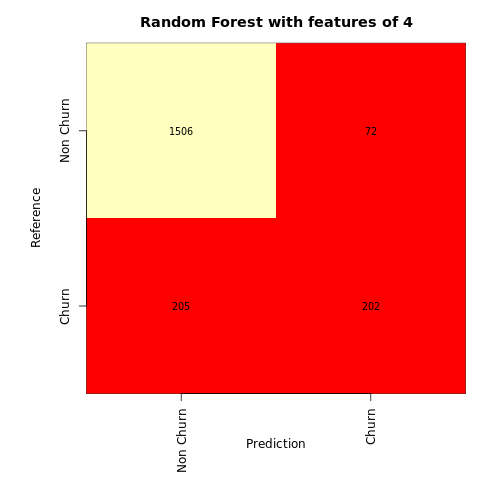

In [ ]:
cfm <- table(y_test, ypred_rfc1_sm)
plot_confusion_matrix(cfm, classes=c('Non Churn','Churn'), title='Random Forest with features of 4')
tn <- cfm[1,1]
fp <- cfm[1,2]
fn <- cfm[2,1]
tp <- cfm[2,2]

Create a confusion matrix for the random forest classifier with six features:

StatementMeta(, 3753b326-451b-4e6b-bf24-9f1372d6e5da, 34, Finished, Available)

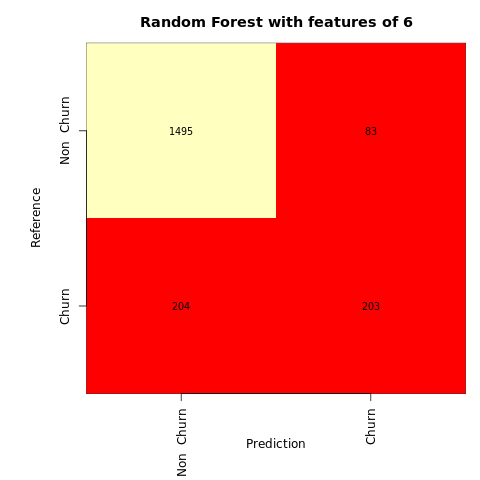

In [ ]:
cfm <- table(y_test, ypred_rfc2_sm)
plot_confusion_matrix(cfm, classes=c('Non  Churn','Churn'), title='Random Forest with features of 6')
tn <- cfm[1,1]
fp <- cfm[1,2]
fn <- cfm[2,1]
tp <- cfm[2,2]

Create a confusion matrix for LightGBM:

StatementMeta(, 3753b326-451b-4e6b-bf24-9f1372d6e5da, 35, Finished, Available)

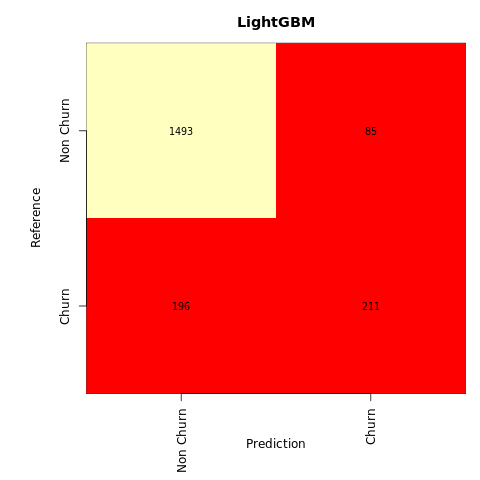

In [ ]:
cfm <- table(y_test, ypred_lgbm1_sm)
plot_confusion_matrix(cfm, classes=c('Non Churn','Churn'), title='LightGBM')
tn <- cfm[1,1]
fp <- cfm[1,2]
fn <- cfm[2,1]
tp <- cfm[2,2]

#### Save results for Power BI

Save the delta frame to the lakehouse, to move the model prediction results to a Power BI visualization:

In [ ]:
df_pred <- X_test
df_pred$y_test <- y_test
df_pred$ypred_rfc1_sm <- ypred_rfc1_sm
df_pred$ypred_rfc2_sm <- ypred_rfc2_sm
df_pred$ypred_lgbm1_sm <- ypred_lgbm1_sm

table_name <- "df_pred_results"
sparkDF <- as.DataFrame(df_pred)
write.df(sparkDF, paste0("Tables/", table_name), source = "delta", mode = "overwrite", overwriteSchema = "true")

cat(paste0("Spark DataFrame saved to delta table: ", table_name))

StatementMeta(, 3753b326-451b-4e6b-bf24-9f1372d6e5da, 36, Finished, Available)

Spark dataframe saved to delta table: df_pred_results

## Step 6: Access visualizations in Power BI

Access your saved table in Power BI:

1. On the left, select **OneLake data hub**
1. Select the lakehouse that you added to this notebook
1. In the **Open this Lakehouse** section, select **Open**
1. On the ribbon, select **New semantic model**. Select `df_pred_results`, and then select **Continue** to create a new Power BI semantic model linked to the predictions
1. On the tools at the top of the dataset page, select **New report** to open the Power BI report authoring page.


The following screenshot shows some example visualizations. The data panel shows the delta tables and columns to select from a table. After selection of appropriate category (x) axis and value (y) axis, you can choose the filters and functions. For example, you can choose a sum or average of the table column.

> [!NOTE]
> The screenshot is an illustrated example that shows the analysis of the saved prediction results in Power BI. For a real use case of customer churn, platform users might need a more thorough ideation of the visualizations to create, based on both subject matter expertise and what the organization and business analytics team and firm have standardized as metrics.

<img src="https://synapseaisolutionsa.blob.core.windows.net/public/bankcustomerchurn/PBIviz3.png"  width="100%" height="100%">

The Power BI report shows that customers who use more than two of the bank products have a higher churn rate. However, few customers had more than two products. (See the plot in the lower-left panel.) The bank should collect more data but also investigate other features that correlate with more products.

Bank customers in Germany have a higher churn rate compared to customers in France and Spain. (See the plot in the lower-right panel.) Based on the report results, an investigation into the factors that encouraged customers to leave might help.

There are more middle-aged customers (between 25 and 45). Customers between 45 and 60 tend to exit more.

Finally, customers with lower credit scores would most likely leave the bank for other financial institutions. The bank should explore ways to encourage customers with lower credit scores and account balances to stay with the bank.

In [ ]:
# Determine the entire runtime
cat(paste0("Full run cost ", as.integer(Sys.time() - ts), " seconds.\n"))

StatementMeta(, 3753b326-451b-4e6b-bf24-9f1372d6e5da, 37, Finished, Available)

Full run cost 111 seconds.